Notes:
- Make sure that all the settings are the same i.e: the optimiser and sigmoided etc.
- Same amount of layers and nodes.
- 

In [48]:
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature # Might not need this.

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

#check the speed of the algorithums agains the direct input -> is lda/pca reduction in accuracy better for the speed?

2.0.0


In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [39]:
# Load in data
trainImages = np.load('trnImage.npy')
trainLabels = np.load('trnLabel.npy')

testImages = np.load('tstImage.npy')
testLabels = np.load('tstLabel.npy')

testLabels = testLabels - 1
trainLabels = trainLabels -1

print(trainLabels.shape)

(10000, 1)


In [40]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [41]:
# Extracting the images from the data.
trainingData = np.zeros((324, 10000))
testingData = np.zeros((324, 1000))

for i in range(10000):
    features, hog_image = computeFeatures(trainImages[:,:,:,i])
    trainingData[:, i] = features

for x in range(1000):
    features, hog_image = computeFeatures(testImages[:,:,:,x])
    testingData[:, x] = features
    

In [42]:
# Change the shape of the matrix

newTrainingData = trainingData.T
newTestingData = testingData.T

In [7]:
#newTrainingData.shape

(10000, 324)

# PCA into NN

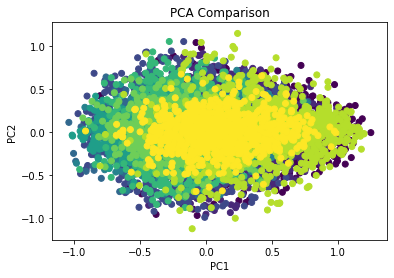

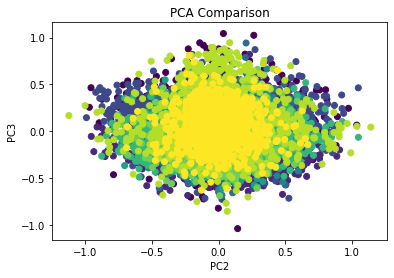

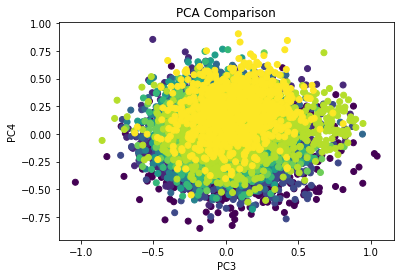

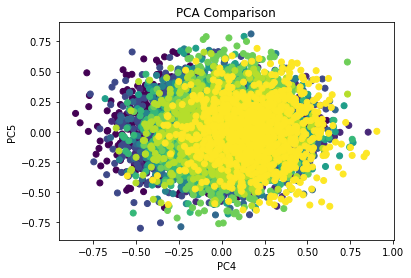

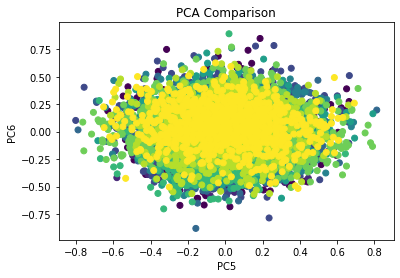

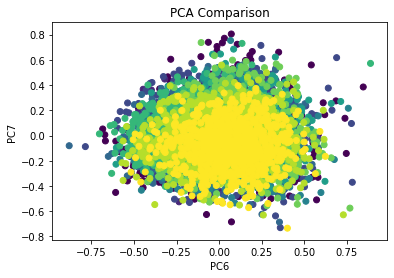

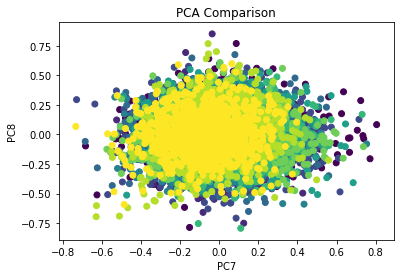

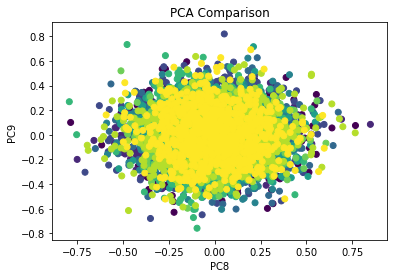

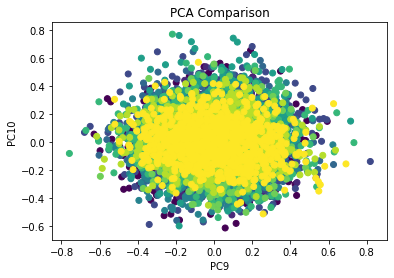

In [45]:
pca = PCA(n_components=100) #n_components = 40

pca.fit(newTrainingData)

pca_train_data = pca.transform(newTrainingData)


for i in range(9):
    plt.scatter(pca_train_data[:, i], pca_train_data[:, i+1], c=trainLabels.ravel())
    plt.xlabel('PC'+ str(i+1))
    plt.ylabel('PC'+ str(i+2))
    plt.title('PCA Comparison')
    plt.show()

pca.fit(newTestingData)

pca_test_data = pca.transform(newTestingData)

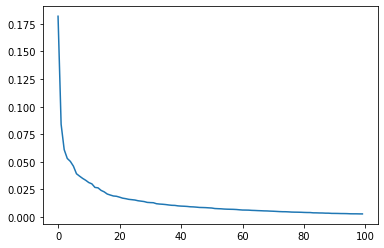

In [46]:
plt.plot(pca.explained_variance_)

In [49]:
# Training the Neural Net with PCA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(pca_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(5, activation='sigmoid')) # first layer
model.add(keras.layers.Dense(5, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(30, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(pca_train_data, trainLabels, validation_data=(pca_test_data, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(pca_test_data)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 20.60%
--- 136.66465091705322 seconds ---


Confusion matrix, without normalization
[[11 16  0  1  5  4  5  4 27 27]
 [17 37  2  0 11  1 11 12  6  3]
 [ 6  6  9  6  6 19 12 16  7 13]
 [ 8  5 20  9  7 13 19 13  1  5]
 [ 4 10 11  3 10  8 17 22  5 10]
 [ 1  2 15  7  2 36 16 16  1  4]
 [ 1  7  4 12  9 15 35  6  0 11]
 [11  5 23  7 12  9  5 23  3  2]
 [27 11  5  1  5  1  3  3 31 13]
 [33 11  9  3 19  2  8  5  5  5]]


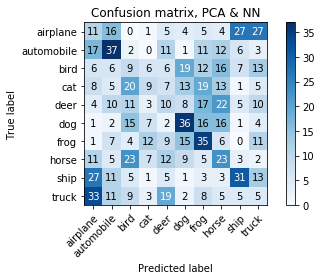

In [51]:
plot_confusion_matrix(testLabels, predicted_labels,classes=trainLabels,
                      title='Confusion matrix, PCA & NN' )

plt.show()

Results:
x3:70 -> 19.10%, x3:20 -> 18.10%, x3:25 -> 20.20%, x3:30 -> 18.20%, x2:20 -> 19.60%, x2:15 -> 18.00% , x1:10 -> 18.20%, x1:5 -> 19.30%, x1:4 -> 17.40%, x2:5 -> 18.00%, 

In [11]:
#predicted_labels.reshape(-1,1)

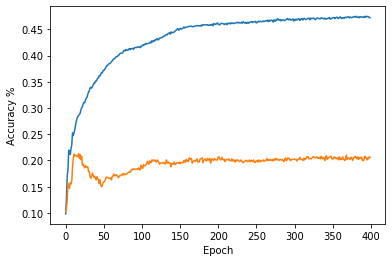

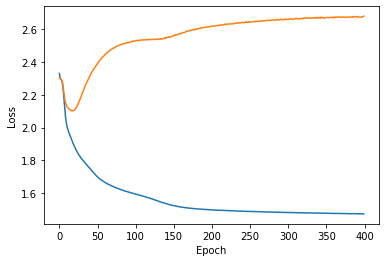

In [52]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Using LDA and feeding through a NN

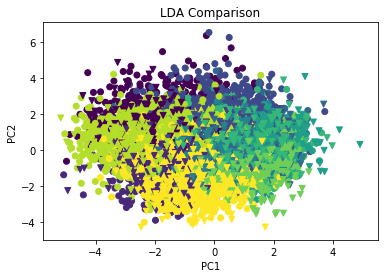

In [53]:
LDA = LinearDiscriminantAnalysis() #n_components=9 -> only can have as many labels there are (10)

#print(my_array.shape)
#print(features.shape)
#print(labels_array)

LDA.fit(newTrainingData, trainLabels.ravel())

lda_new_train_data = LDA.transform(newTrainingData)

plt.scatter(lda_new_train_data[:, 0], lda_new_train_data[:, 1], c=trainLabels.ravel())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('LDA Comparison')


LDA.fit(newTestingData, testLabels.ravel())

lda_new_test_data = LDA.transform(newTestingData)

plt.scatter(lda_new_test_data[:, 0], lda_new_test_data[:, 1], c=testLabels.ravel(), marker='v')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('LDA Comparison')
plt.show()

In [54]:
# Training the Neural Net with LDA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(lda_new_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(4, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # third layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # forth layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(lda_new_train_data, trainLabels, validation_data=(lda_new_test_data, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(lda_new_test_data)

print("--- %s seconds ---" % (time.time() - start_time))

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))




--- 121.72978210449219 seconds ---
Percentage accuracy on testing set is: 56.30%


Confusion matrix, without normalization


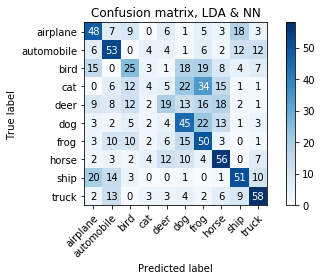

In [66]:
#print(confusion_matrix(testLabels, predicted_labels))
plot_confusion_matrix(testLabels, predicted_labels,classes=trainLabels,
                      title='Confusion matrix, LDA & NN' )

plt.show()
#data melt

Results: 
28:11 (sigmoid/op=adam) -> x3:70 -> 30.60%, x3:25 -> 36.20%, x2:25 -> 38.00%, x2:15 -> %35.70%, x2:20 -> 35.70%, x3:25 -> 36.70%, x3:15 -> 35.60%, x4:15 -> 38.50%, x4:20 -> 38.60%, x4:25 -> 35.60%, x4:22 -> 36.00%, x4:21 -> 36.60, x1:20 -> 35.30%, x1:10 -> 37.30%, x1:5 -> 48.20%, x1:4 -> 55.50%, x1:3 -> 48.30%, x1:4 -> 55.00% (second attempt), x2:4 -> 52.4%, x2:3 -> 49.00%, x2:6 -> 44.40%, x2:100 -> 31.70%, x1:4 -> 54.90%, x1:100 -> 35.00% 113s, x2:100 -> 32.10% 130s, (op=sgd) x2:100 -> 36.90% 105s, x1:4 -> 54.30% 95s, x1:4(40) -> 53.90% 95s, x1:4 -> 56.30% 121s, 

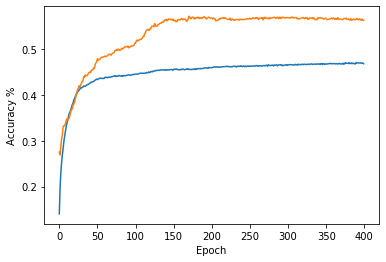

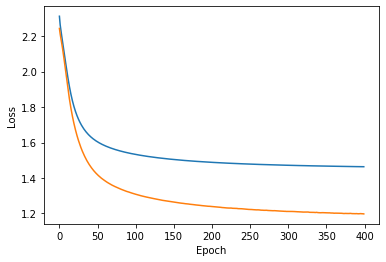

In [57]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## SVM

In [58]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
SVMmodel = SVC(kernel='sigmoid', C=C, gamma=0.1)



# Normalise the data based on the training set
normaliser = StandardScaler().fit(newTrainingData)
train_data = normaliser.transform(newTrainingData)
test_data = normaliser.transform(newTestingData)

y_pred = SVMmodel.fit(train_data, trainLabels).predict(test_data)
#SVMpredicted_labels = SVMmodel.predict(test_data)

accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print()

/Users/andy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Percentage accuracy on testing set is: 56.30%



28:11:1 -> 30.60%, 2 -> 36.00%, (sigmoid) 1-> 44.40% 2-> 54.90%  (linear) 48.50%


Confusion matrix, without normalization
[[17 40  4  1  2  3  7  5 19  2]
 [ 3 42  2  3  2  4 16  8 20  0]
 [ 8  8 10  3  4 32 15  7 11  2]
 [ 2 11 13  5  4 15 36  7  6  1]
 [ 6 12  5  8 15 12 27  5 10  0]
 [ 2  8 12  9  1 20 31 13  4  0]
 [ 4  9  5 15  6 23 28  8  2  0]
 [ 5  9  9  8  4 24 17 16  7  1]
 [14 31  1  1  2  0 11  3 35  2]
 [ 3 19  1  5  5 11  1 11 35  9]]


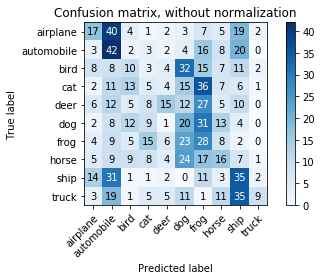

In [59]:
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(testLabels, y_pred, classes=trainLabels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(test_data, y_pred, classes=testLabels, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

# PCA into LDA into SVM

In [67]:
# PCA
pca = PCA(n_components=100) #n_components = 40

pca.fit(newTrainingData)

pca_lda_train_data = pca.transform(newTrainingData)

pca.fit(newTestingData)

pca_lda_test_data = pca.transform(newTestingData)

In [68]:
LDA.fit(pca_lda_train_data, trainLabels.ravel())

pca_lda_train_data = LDA.transform(pca_lda_train_data)

LDA.fit(pca_lda_test_data, testLabels.ravel())

pca_lda_test_data = LDA.transform(pca_lda_test_data)

In [69]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
SVMmodel = SVC(kernel='sigmoid', C=C, gamma=0.1)



# Normalise the data based on the training set
normaliser = StandardScaler().fit(pca_lda_train_data)
train_data = normaliser.transform(pca_lda_train_data)
test_data = normaliser.transform(pca_lda_test_data)

y_pred = SVMmodel.fit(train_data, trainLabels).predict(test_data)

accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print()

/Users/andy/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Percentage accuracy on testing set is: 40.90%



Confusion matrix, without normalization


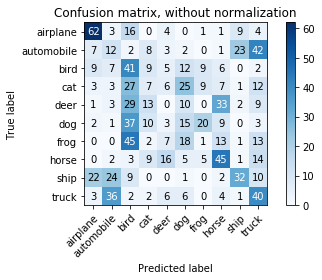

In [70]:
plot_confusion_matrix(testLabels, y_pred, classes=trainLabels,
                      title='Confusion matrix, without normalization')

plt.show()

# Data straight into NN

In [60]:
# Training the Neural Net with LDA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(newTrainingData.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(4, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer
# optimizer = "adam"
# Fit our model to the data
history = model.fit(newTrainingData, trainLabels, validation_data=(newTestingData, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(newTestingData)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 40.90%
--- 123.79762697219849 seconds ---


28:11 -> x3:25 -> 50.70%, x1:24 -> 49.2%, x1:25 -> 50.60%, x1:4 -> 43.10%, x1:100 -> 51.00% 111s, x2:100 -> 47.70% 117s, x3:100 -> 32.90% 124s, x1:4 -> % s, 

Confusion matrix, without normalization
[[48  7  9  0  6  1  5  3 18  3]
 [ 6 53  0  4  4  1  6  2 12 12]
 [15  0 25  3  1 18 19  8  4  7]
 [ 0  6 12  4  5 22 34 15  1  1]
 [ 9  8 12  2 19 13 16 18  2  1]
 [ 3  2  5  2  4 45 22 13  1  3]
 [ 3 10 10  2  6 15 50  3  0  1]
 [ 2  3  2  4 12 10  4 56  0  7]
 [20 14  3  0  0  1  0  1 51 10]
 [ 2 13  0  3  3  4  2  6  9 58]]


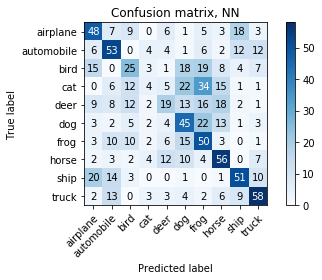

In [61]:
plot_confusion_matrix(testLabels, predicted_labels,classes=trainLabels,
                      title='Confusion matrix, NN' )

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(new_my_array, trainLabels).predict(newTestingData)


def plot_confusion_matrix(history, predicted_probabilities, predicted_labels):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if not title:
    #    if normalize:
    #        title = 'Normalized confusion matrix'
    #    else:
    #        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(history, predicted_probabilities)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(history, predicted_probabilities)]
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           #title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(newTestingData, predicted_probabilities, predicted_labels)

# Plot normalized confusion matrix
#plot_confusion_matrix(newTestingData, y_pred, classes=testLabels,
#                      title='Normalized confusion matrix')

plt.show()

In [ ]:
#classifier = svm.SVC(kernel='sigmoid', C=1)
#y_pred = classifier.fit(train_data, trainLabels).predict(test_data)

#class_names = #create a dictionary

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(testLabels, y_pred, classes=trainLabels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(test_data, y_pred, classes=testLabels, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()